# Support Vector Machine

### Python Implementation

## Support Vector Machine

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt #data visualization
import numpy as np #linear Algebra
from scipy.io import loadmat #load .mat files
from sklearn.svm import SVC #Support vector classifier

In the first half of this exercise, we will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help us  gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, we will be using support vector machines to build a spam classifier.

We will begin with a 2D example dataset which can be separated by a linear boundary. In this dataset, the positions of the positive examples (indicated with +) and the negative examples (indicated with o) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example (+) on the far left at about (0:1; 4:1). As part of this exercise, we will also see how this outlier affects the SVM decision boundary.

In [2]:
data = loadmat('ex6data1.mat')
X,y = data['X'], data['y'].ravel()

In [3]:
print(X.shape, y.shape)

(51, 2) (51,)


In [4]:
def plotData(X,y):
    plt.figure(figsize=(10,7))
    plt.plot(X[y==1][:,0], X[y==1][:,1], 'kx', label = 'Positive Example')
    plt.plot(X[y==0][:,0], X[y==0][:,1], 'yo', label = 'Negative Example')
    plt.grid()
    plt.legend()
    plt.ylabel('Column 2 Example')
    plt.xlabel('Column 1 Example')

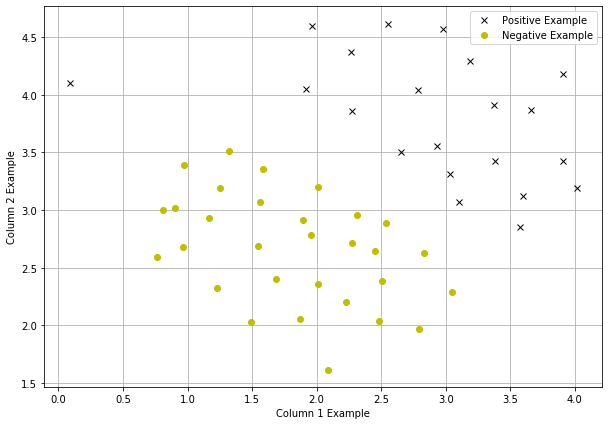

In [5]:
plotData(X,y)

### Effect of varying the C parameter

Informally, the $C$ parameter is a positive value that controls the penalty for misclassiffed training examples. A large $C$ parameter tells the SVM to try to classify all the examples correctly. $C$ plays a role similar to $1/\lambda$, where $\lambda$ is the regularization parameter used in logistic regression

In [6]:
def plotDecisionBoundary(model,X,y):
    xmin,xmax = X[:,0].min()-0.1, X[:,0].max()+0.1
    ymin,ymax = X[:,1].min()-0.1, X[:,1].max() +0.1
    x, y = np.meshgrid(np.arange(xmin, xmax, 0.1),
                         np.arange(ymin, ymax, 0.1))
    Xplot = np.c_[x.ravel(), y.ravel()]
    yplot = model.decision_function(Xplot).reshape(x.shape)
    plt.contour(x, y, yplot, levels=[0], colors='b')

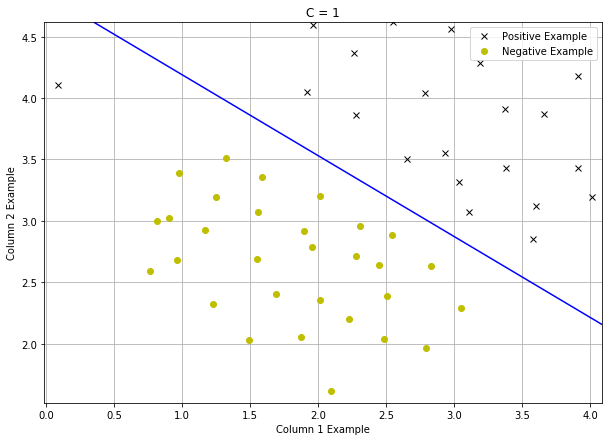

In [7]:
model = SVC(C=1, kernel='linear')
model.fit(X, y)
plotData(X,y)
plt.title("C = 1")
plotDecisionBoundary(model, X, y)

When $C = 1$, the SVM puts the decision boundary in the gap between the two datasets and misclassifies the data point on the far left

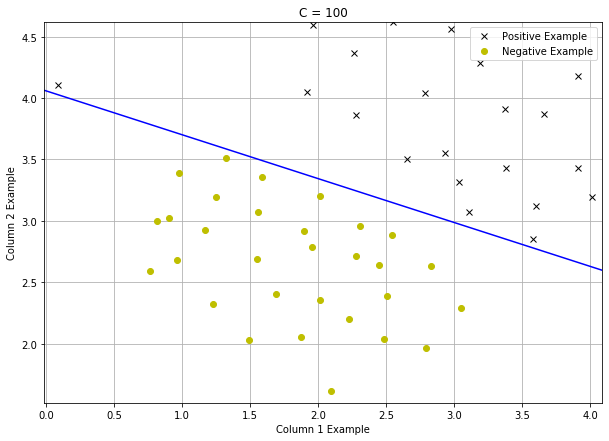

In [8]:
model = SVC(C=100, kernel='linear')
model.fit(X, y)
plotData(X,y)
plt.title("C = 100")
plotDecisionBoundary(model, X, y)

When $C = 100$, the SVM now classifies every single example correctly, but has a decision boundary that does not appear to be a natural fit for the data

### SVM with gaussian kernels

To find nonlinear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the 'distance' between a pair of examples, $(x^{(i)}, x^{(j)})$. The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart.

The Gaussian kernel function is dened as:

$$K_{gaussian}(x^{(i)},x^{(j)})
=\exp\left(-\frac{\left\| x^{(i)}-x^{(j)}\right\|^2}{2\sigma^2}\right)
=\exp\left(-\frac{\sum_{k=1}^n{(x_k^{(i)}-x_k^{(j)})^2}}{2\sigma^2}\right)$$

In [9]:
#This is just an example of the gausian Kernel function. 
#I will otherwise use sklearn's the inbuilt function as it is higly optimized
def gaussianKernel(x1,x2,sigma):
    sqdiff = np.sum((x1-x2)**2)
    return np.exp(-sqdiff/(2*(sigma**2)))

x1,x2,sigma = np.array([1, 2, 1]), np.array([0, 4 ,-1]), 2
sim = gaussianKernel(x1, x2, sigma)

print(round(sim,6))

0.324652


###  Example dataset 2

In [10]:
data = loadmat('ex6data2.mat')
X,y = data['X'], data['y'].ravel()

In [11]:
print(X.shape,y.shape)

(863, 2) (863,)


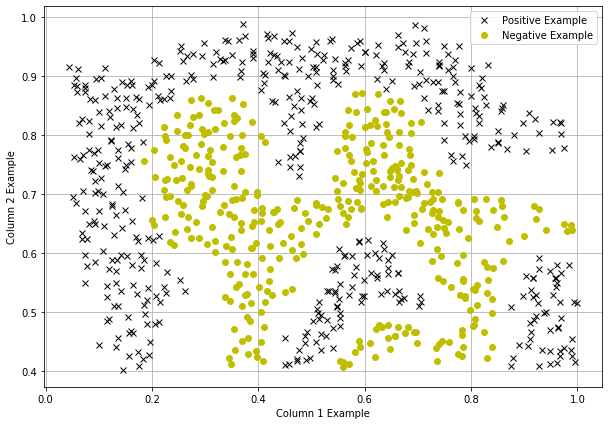

In [12]:
plotData(X,y)

 From the figure, you can observe that there is no linear decision boundary that separates the positive and negative examples for this dataset. 
 
 However, by using the Gaussian kernel with the SVM, we will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset.

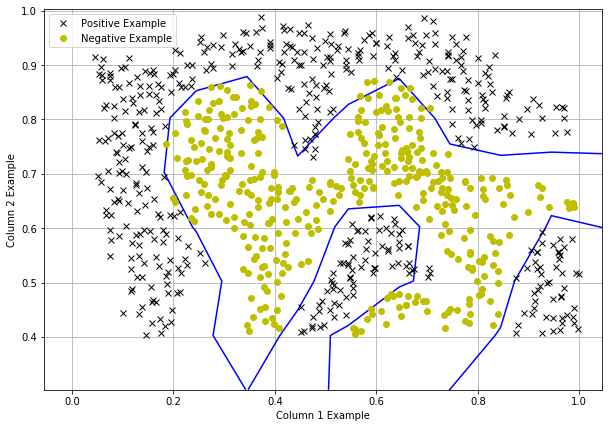

In [13]:
gamma = 0.1**-2
model = SVC(C=1, kernel='rbf',gamma=gamma)
model.fit(X,y)
plotData(X,y)
plotDecisionBoundary(model,X,y)

The decision boundary found by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

### Example dataset 3

In [14]:
data = loadmat('ex6data3.mat')
X,y = data['X'],data['y'].ravel()
Xval,yval = data['Xval'], data['yval'].ravel()

In [15]:
print(X.shape,y.shape)
print(Xval.shape,yval.shape)

(211, 2) (211,)
(200, 2) (200,)


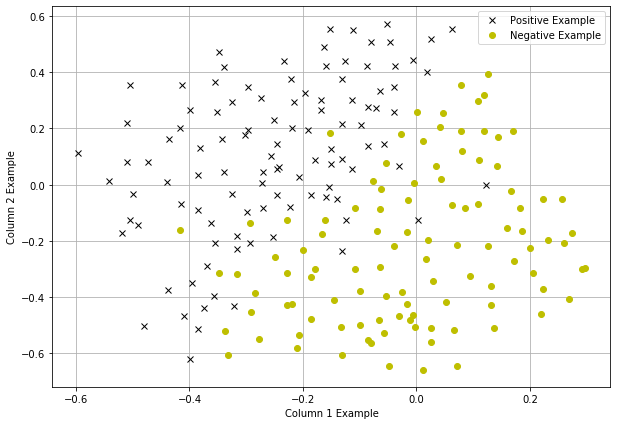

In [16]:
plotData(X,y)

To find the best parameters $C$ and $\sigma$ to use in the gaussian kernel for classifying the above data, we will use a range of different incremental values of both parameters on the training set an select the pair that performs well on the cross validation data set i.e. the one with the smallest cost

For both $C$ and $\sigma$ we wil try values in multiplicative steps (e.g., 0.01, 0,03, 0.1, 0.3, 1, 3, 10, 30). Note that we will try all possible pairs of values for $C$ and  $\sigma$ (e.g. $C = 0.3$,  and $\sigma= 0.1$ ). For example, if you try each of the 8 values listed above for $C$ and for $\sigma^2$, you would end up training and evaluating (on the cross validation set) a total of  $8^2$= 64.

In [17]:
test_vals = [ 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30]
best_score = -np.inf
best_sigma,best_C = 0,0
for c in test_vals:
    for sigma in test_vals:
        model = SVC(C=c, gamma=sigma)
        model.fit(X,y)
        score = model.score(Xval,yval)
        if score > best_score:
            best_score = score
            best_C =c
            best_sigma = sigma
print(f'The best values are C = {best_C}, sigma = {best_sigma}, score = {best_score}')

The best values are C = 3, sigma = 30, score = 0.965


Next, We visualize the decision boundary of the model trained with the best parameters

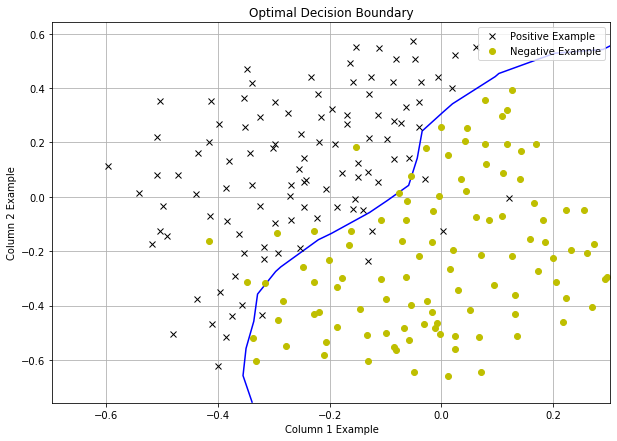

In [18]:
model = SVC(C=best_C, kernel='rbf', gamma=best_sigma)
model.fit(X,y)
plotData(X,y)
plt.title('Optimal Decision Boundary')
plotDecisionBoundary(model,X,y)

## Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, we will use SVMs to build our own spam filter. We will be training a classifier to classify whether a given email, $x$, is spam ($y=1$) or non-spam ($y=0$). In particular, we need to convert each email into a feature vector $x\in\mathbb{R}^n$

 ### Preprocessing emails

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset.A sample email may contain a URL, an email address (at the end), numbers, and dollar amounts. While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specic URL or specific dollar amount) will be different in almost every email.

Therefore, one method often employed in processing emails is to 'normalize' these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the email with the unique string "httpaddr" to indicate that a URL was present. This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small.

In processing the email we will implement the following email preprocessing and normalization steps:

    1.Lower-casing: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as indicate).
    2.Stripping HTML: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.
    3.Normalizing URLs: All URLs are replaced with the text "httpaddr".
    4.Normalizing Email Addresses: All email addresses are replaced with the text "emailaddr".
    5.Normalizing Numbers: All numbers are replaced with the text 'number'.
    6.Normalizing Dollars: All dollar signs ($) are replaced with the text 'dollar'.
    7.Word Stemming: Words are reduced to their stemmed form. For example, 'discount', 'discounts', 'discounted' and 'discounting' are all replaced with 'discount'. Sometimes, the Stemmer actually strips off additional characters from the end, so 'include', 'includes', 'included', and 'including' are all replaced with 'includ'.
    8.Removal of non-words: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

In [19]:
import re
from nltk.stem import PorterStemmer

In [20]:
email = open('emailSample1.txt','r').read()
vocabList = open('vocab.txt','r').read() # list of words that commonly occur in spam emails

In [21]:
#visulalize the sample email
email

"> Anyone knows how much it costs to host a web portal ?\n>\nWell, it depends on how many visitors you're expecting.\nThis can be anywhere from less than 10 bucks a month to a couple of $100. \nYou should checkout http://www.rackspace.com/ or perhaps Amazon EC2 \nif youre running something big..\n\nTo unsubscribe yourself from this mailing list, send an email to:\ngroupname-unsubscribe@egroups.com\n\n"

We will create a dictionary from the vocablist. This will allow easier look up i.e check if a word in the email is a commonly occuring word in spam emails

In [22]:
vocabList_dict ={}

for w in vocabList.strip().split('\n'):
    ls = w.split('\t')
    index,word = ls[0], ls[1]
    vocabList_dict[word] = int(index)

In [23]:
def processEmail(email, vocab_List):
    #make email lower case
    email = email.lower()
    
    # Strip all HTML
    email = re.sub('<[^<>]+>',' ',email)
    
    # Handle Numbers
    # Look for one or more characters between 0-9
    email = re.sub('[0-9]+', 'number',email)
    
    # Handle URLS
    # Look for strings starting with http:// or https://
    email = re.sub('(http|https)://[^\s]*', 'httpaddr',email)
    
    # Handle Email Addresses
    # Look for strings with @ in the middle
    email = re.sub('[^\s]+@[^\s]+', 'emailaddr',email)
    
    #Handle $ sign
    email = re.sub('[$]+', 'dollar',email)
    
    # Remove any non alphanumeric characters
    email = re.sub('[^a-zA-Z0-9]', ' ',email)
    
    #stem the words
    ps = PorterStemmer()
    email = [ps.stem(token) for token in email.split(' ')]
    email = ' '.join(email)
    
    #Get the word indices from the vocab_list
    word_indices =[] 
    for word in email.split():
        if len(word)>1 and word in  vocab_List:
            word_indices.append(vocab_List[word])
    return word_indices

In [24]:
word_indices = processEmail(email,vocabList_dict)
print(np.array(word_indices))

[  86  916  794 1077  883  370 1699  790 1822 1831  883  431 1171  794
 1002 1893 1364  592 1676  238  162   89  688  945 1663 1120 1062 1699
  375 1162  479 1893 1510  799 1182 1237  810 1895 1440 1547  181 1699
 1758 1896  688 1676  992  961 1477   71  530 1699  531]


### Extracting features from emails

We will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, you will be using words in vocabulary list. Specically, the feature $x_i\in\{0,\;1\}$ for an email corresponds to whether the $i$-th word in the dictionary occurs in the email. That is, $x_i = 1$ if the $i$-th word is in the email and $x_i = 0$ if the $i$-th word is not present in the email.

Concretely, if an email has the text:

                The quick brown fox jumped over the lazy dog.
                
Then, the word_indices vector for this text might look like:  

                   60  100   33   44   10     53  60  58   5
                   
where, we have mapped each word onto a number, for example:

                   the   -- 60
                   quick -- 100
                   ...

(note: the above numbers are just an example and are not the actual mappings).

Our task is take one such word_indices vector and construct a binary feature vector that indicates whether a particular
word occurs in the email. That is, x(i) = 1 when word i is present in the email. Concretely, if the word 'the' (say, index 60) appears in the email, then x(60) = 1. The feature vector should look like:

              x = [ 0 0 0 0 1 0 0 0 ... 0 0 0 0 1 ... 0 0 0 1 0 ..]

In [25]:
def emailFeatures(word_indices,vocab_List):
    n = len(vocab_List)
    features = np.zeros((n,1))
    features[word_indices] = 1
    return features

In [26]:
features = emailFeatures(word_indices,vocabList_dict)
print("Length of feature vector: ",len(features))
print("Number of non-zero entries: ",np.sum(features))

Length of feature vector:  1899
Number of non-zero entries:  45.0


## Training SVM for spam classification

In this section we will load a preprocessed training dataset that will be used to train an SVM classifier. spamTrain.mat contains 4000 training examples of spam and non-spam email, while spamTest.mat contains 1000 test examples. Each original email was processed using the processEmail and emailFeatures functions and converted into a vector $x^{(i)}\in\mathbb{R}^{1899}$. After loading the dataset, we will proceed to train a SVM to classify between spam ($y = 1$) and non-spam ($y = 0$) emails

In [27]:
data = loadmat('spamTrain.mat')
X_train = data['X']
y_train = data['y'].ravel()

In [28]:
classifier = SVC(C=0.1, kernel='linear')
classifier.fit(X_train,y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [29]:
score = classifier.score(X_train,y_train)
print(f'The training accuracy is {score*100}%')

The training accuracy is 99.825%


In [30]:
#test data 
data = loadmat('spamTest.mat')
X_test = data['Xtest']
y_test = data['ytest'].ravel()

In [31]:
#test accuracy
score = classifier.score(X_test,y_test)
print(f'The training accuracy is {score*100}%')

The training accuracy is 98.9%


### Try your own emails

#### 1. Non Spam Emails

In [32]:
email = open('emailSample1.txt','r').read()

In [33]:
email

"> Anyone knows how much it costs to host a web portal ?\n>\nWell, it depends on how many visitors you're expecting.\nThis can be anywhere from less than 10 bucks a month to a couple of $100. \nYou should checkout http://www.rackspace.com/ or perhaps Amazon EC2 \nif youre running something big..\n\nTo unsubscribe yourself from this mailing list, send an email to:\ngroupname-unsubscribe@egroups.com\n\n"

In [34]:
predictions = lambda x: 'Spam' if x else 'Non Spam'

In [35]:
#get word indices
word_indices = processEmail(email,vocabList_dict)

In [36]:
#get features
features = emailFeatures(word_indices, vocabList_dict)

In [37]:
#predict
pred =classifier.predict(features.T)
predictions(pred[0])

'Non Spam'

The classifier Correctly predicts the email as Non Spam

In [39]:
email2 = open('emailSample2.txt','r').read()

In [40]:
email2

'Folks,\n \nmy first time posting - have a bit of Unix experience, but am new to Linux.\n\n \nJust got a new PC at home - Dell box with Windows XP. Added a second hard disk\nfor Linux. Partitioned the disk and have installed Suse 7.2 from CD, which went\nfine except it didn\'t pick up my monitor.\n \nI have a Dell branded E151FPp 15" LCD flat panel monitor and a nVidia GeForce4\nTi4200 video card, both of which are probably too new to feature in Suse\'s default\nset. I downloaded a driver from the nVidia website and installed it using RPM.\nThen I ran Sax2 (as was recommended in some postings I found on the net), but\nit still doesn\'t feature my video card in the available list. What next?\n \nAnother problem. I have a Dell branded keyboard and if I hit Caps-Lock twice,\nthe whole machine crashes (in Linux, not Windows) - even the on/off switch is\ninactive, leaving me to reach for the power cable instead.\n \nIf anyone can help me in any way with these probs., I\'d be really grateful

In [41]:
word_indices = processEmail(email2, vocabList_dict)

In [42]:
features2 = emailFeatures(word_indices,vocabList_dict)

In [43]:
#try with our old classifier
pred = classifier.predict(features2.T)
predictions(pred[0])

'Non Spam'

It correctly classified the email

#### 2. Spam Emails

In [44]:
spam = open('spamSample1.txt','r').read()

In [45]:
spam

'Do You Want To Make $1000 Or More Per Week?\n\n \n\nIf you are a motivated and qualified individual - I \nwill personally demonstrate to you a system that will \nmake you $1,000 per week or more! This is NOT mlm.\n\n \n\nCall our 24 hour pre-recorded number to get the \ndetails.  \n\n \n\n000-456-789\n\n \n\nI need people who want to make serious money.  Make \nthe call and get the facts. \n\nInvest 2 minutes in yourself now!\n\n \n\n000-456-789\n\n \n\nLooking forward to your call and I will introduce you \nto people like yourself who\nare currently making $10,000 plus per week!\n\n \n\n000-456-789\n\n\n\n3484lJGv6-241lEaN9080lRmS6-271WxHo7524qiyT5-438rjUv5615hQcf0-662eiDB9057dMtVl72\n\n'

In [46]:
word_indices = processEmail(spam, vocabList_dict)
features = emailFeatures(word_indices, vocabList_dict)

In [47]:
pred =classifier.predict(features.T)
predictions(pred[0])

'Non Spam'

The classifier missclassifies what is clearly a spam email. perhaps tweaking the C value would result in a better classification

In [48]:
improved = SVC(C=1, kernel='linear')
improved.fit(X_train,y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [49]:
pred = improved.predict(features.T)
predictions(pred[0])

'Spam'

With an increased C value the classifier now correctly classifies the email

In [50]:
#second example
spam2 = open('spamSample2.txt','r').read()
spam2

'Best Buy Viagra Generic Online\n\nViagra 100mg x 60 Pills $125, Free Pills & Reorder Discount, Top Selling 100% Quality & Satisfaction guaranteed!\n\nWe accept VISA, Master & E-Check Payments, 90000+ Satisfied Customers!\nhttp://medphysitcstech.ru\n\n\n'

In [51]:
word_indices = processEmail(spam2, vocabList_dict)
features2 = emailFeatures(word_indices,vocabList_dict)

In [52]:
pred = classifier.predict(features2.T)
predictions(pred[0])

'Spam'

In [53]:
pred = improved.predict(features2.T)
predictions(pred[0])

'Spam'

Both classifiers are spot on in their classification of the secon example